# Hyperparameters

| hyperparameter|FP|AIT|FLVL|FLVU|HCOM|
|--------------:|-:|--:|---:|---:|---:|
| hidden_size | 64 | 128 | 256 | 512 | 256 |
| dropout | 0.279 | 0.298 | 0.238 | 0.268 | 0.276 |
| num_layers | 3 | 3 | 4 | 6 | 7 |
| num_timesteps | 5 | 8 | 5 | 6 | 4 |
| lr_init | 0.01 | 0.001 | 0.0001 | 0.0001 | 0.0001 |
| gamma | 0.978 | 0.982 | 0.979 | 0.979 | 0.986 |
| weight_decay | 3.82 $\times$ 10$^{-3}$ | 2.37 $\times$ 10$^{-4}$ | 1.39 $\times$ 10$^{-2}$ | 6.36 $\times$ 10$^{-2}$ | 6.72 $\times$ 10$^{-3}$ |

# Parameter Setting

In [1]:
parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'HCOM',
    hidden_size = 256,
    dropout = 0.276,
    num_layers = 7,
    num_timesteps = 4,
    lr_init = 0.0001,
    gamma = 0.986,
    weight_decay = 6.72E-3,
)

DATAPATH = "/SSD2/bgkang/Chemomile"

MODELPATH = dict(
    FP = "../Model/FP-2024-07-17-02-08-03", # FP
    AIT = "../Model/AIT-2024-07-17-02-21-21", # AIT
    FLVL = "../Model/FLVL-2024-07-17-02-25-23", # FLVL
    FLVU = "../Model/FLVU-2024-07-17-02-29-19", # FLVU
    HCOM = "../Model/HCOM-2024-07-17-04-48-42", # HCOM
)

# Serotonin
SMILES = "C1=CC2=C(C=C1O)C(=CN2)CCN"; TRUE_VAL = 205.4 + 273.15
# Cinnamaldehyde
# SMILES = "O=CC=Cc1ccccc1"; TRUE_VAL = 71 + 273.15
# 1,1'-(1,3-Phenylene)bis(1H-pyrrole-2,5-dione)
# SMILES = "CC1=CC(=O)N(C1=O)CC2=CC(=CC=C2)CN3C(=O)C=C(C3=O)C"; TRUE_VAL = 250.7 + 273.15
# Adrenosterone
# SMILES = "CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C"; TRUE_VAL = 206.0 + 273.15
# 4-Nitrotoluene
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 379 # FP
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 1.6 # FLVL

SYMBOL = dict([(1, "H"), (6, "C"), (8, "O"), (7, "N"), (0, "*")]) # Atomic Symbol

# Prediction

In [2]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import Explainer

In [3]:
dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
data = smiles2data(SMILES, TRUE_VAL)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH[parameters['target']]))
model.eval()

	DataDump found for 'HCOM'. Loading dumped data.
Training : 727 | Validation : 91 | Test : 91
Total : 909


Chemomile(
  (atom_encoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (subfrag_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fragment_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (molecule_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fully_connected): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.276, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [4]:
explainer = Explainer(
    model = model,
    data = data
)

pred = explainer.ref * dataset.std + dataset.mean

nameset = [data.smiles for data in dataset.total_set]

if SMILES in nameset:
    print(f"{SMILES} is already in the dataset.")
print(f"| SMILES : {data.smiles} | TRUE : {data.y:.3f} | PRED : {pred:.3f} |")

| SMILES : C1=CC2=C(C=C1O)C(=CN2)CCN | TRUE : 478.550 | PRED : -5.755 |


# Explain

In [5]:
score = explainer.atomMask()
score

[tensor([0.0443]),
 tensor([0.0281]),
 tensor([0.0067]),
 tensor([0.0248]),
 tensor([0.0575]),
 tensor([0.0018]),
 tensor([-0.0131]),
 tensor([0.0113]),
 tensor([0.0332]),
 tensor([0.0208]),
 tensor([-0.0239]),
 tensor([-0.0508]),
 tensor([-0.0450]),
 tensor([0.0239]),
 tensor([0.0180]),
 tensor([0.0264]),
 tensor([-0.0085]),
 tensor([0.0190]),
 tensor([0.0143]),
 tensor([-0.0007]),
 tensor([-0.0016]),
 tensor([-0.0009]),
 tensor([-0.0008]),
 tensor([-0.0084]),
 tensor([-0.0095])]

# Visualization

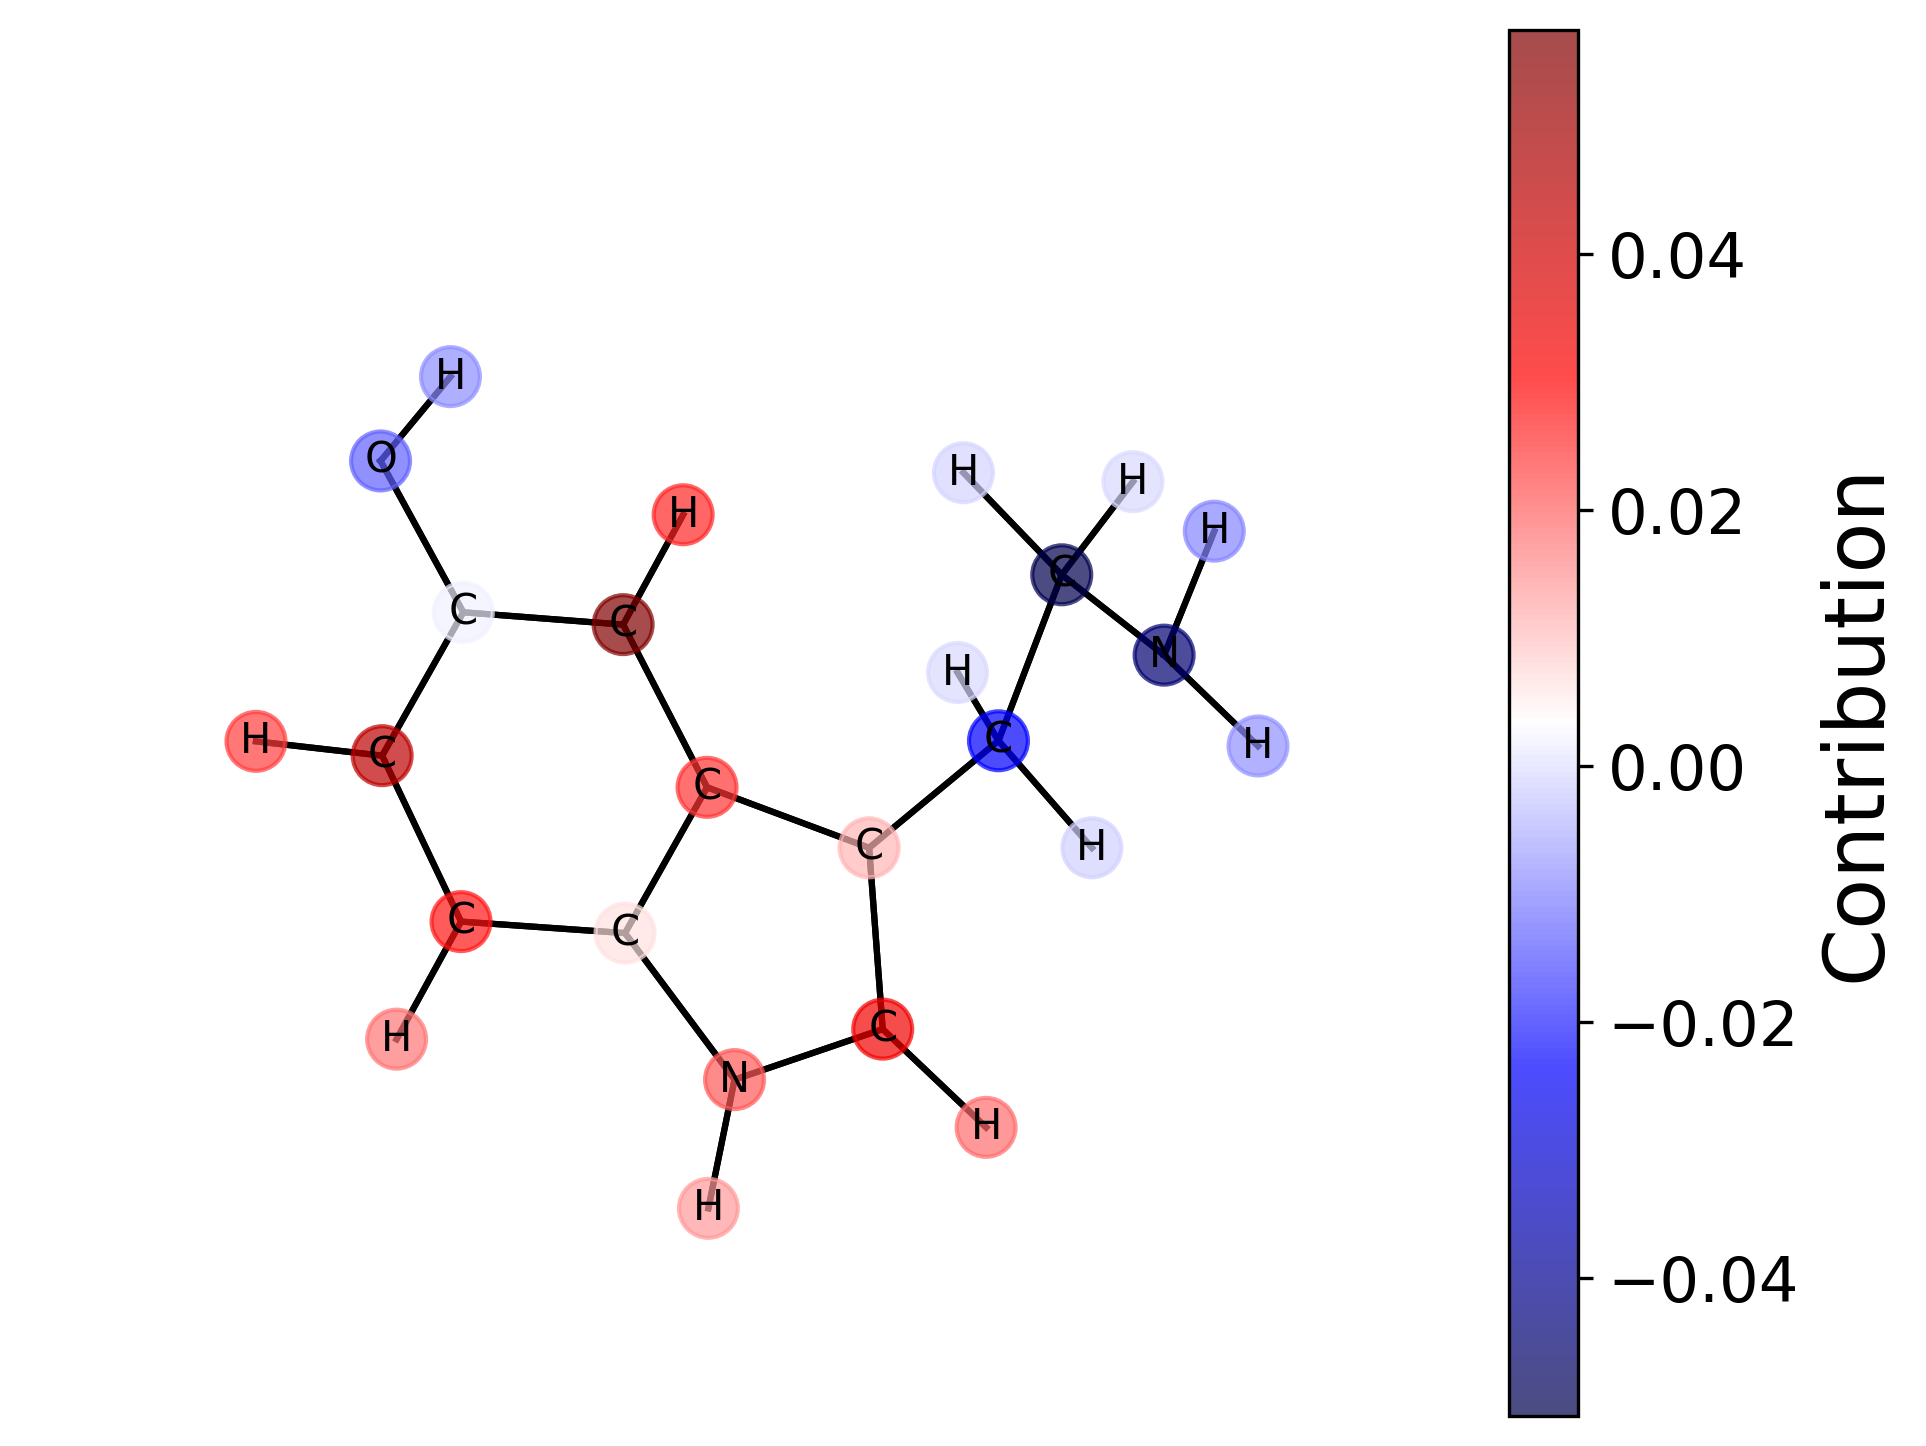

In [6]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi = 300,
                       subplot_kw = dict(projection = '3d'))

p = explainer.plot(ax)

ax.dist = 100

ax.view_init(azim = -100, elev = 73, roll = 0)
ax.set_box_aspect(None, zoom = 1.25)

cb = fig.colorbar(p)
cb.set_label("Contribution", fontsize = 20)
cb.ax.tick_params(labelsize = 15)

plt.savefig(f"./explain_results/{parameters['target']}_{SMILES}.png", dpi = 300)
plt.show()